Ref
- https://github.com/philipperemy/keras-attention-mechanism

In [1]:
# can attention model figure out dependent variable
# ex) v = vector with 32 values
# v[1] == target & all other values are randomly chosen
# can the model understand the importance of v[1]?

In [2]:
import numpy as np
from keras import backend as K
from keras.models import *
from keras.layers import Input, Dense, multiply
from keras.layers.recurrent import LSTM
from keras.layers.core import *
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [3]:
data_c = 10000
input_dims = 32
attention_column = 7

In [4]:
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    activations = []
#     inp =  model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name==layer_name]
#     print(model.layers)
#     print(outputs)
    funcs = [K.function([model.input] + [K.learning_phase()], [out]) for out in outputs]
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

In [5]:
def generate_date(batch_size, input_size, attention_index):
    train_x = np.random.standard_normal(size=(batch_size, input_size))
    train_y = np.random.randint(low=0, high=2, size=(batch_size, 1))
    train_x[:, attention_index] = train_y[:, 0]
    return (train_x, train_y)

train_x, train_y = generate_date(data_c, input_dims, attention_column)
test_x, test_y = generate_date(1, input_dims, attention_column)

### Dense- Attention

In [6]:
def build_model():
    # input layer
    input_layer = Input(shape=(input_dims,))
    
    # attention layer
    attention_prob = Dense(input_dims, activation='softmax', name='attention_vec')(input_layer)
    attention_mul = multiply([input_layer, attention_prob])
    
    # fully connected layer
    y = Dense(64)(attention_mul)
    y = Dense(1, activation='sigmoid')(y)
    
    model = Model(input_layer, y)
    return model

In [7]:
model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
attention_vec (Dense)           (None, 32)           1056        input_1[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 32)           0           input_1[0][0]                    
                                                                 attention_vec[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           2112        multiply_1[0][0]                 
__________

In [9]:
model.fit(train_x, train_y, epochs=10, batch_size=64, validation_split=0.2, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 8000 samples, validate on 2000 samples
Epoch 1/10
 - 0s - loss: 0.6775 - acc: 0.6259 - val_loss: 0.6452 - val_acc: 0.7000
Epoch 2/10
 - 0s - loss: 0.5721 - acc: 0.7490 - val_loss: 0.4913 - val_acc: 0.7860
Epoch 3/10
 - 0s - loss: 0.4088 - acc: 0.8345 - val_loss: 0.3253 - val_acc: 0.8845
Epoch 4/10
 - 0s - loss: 0.2351 - acc: 0.9237 - val_loss: 0.1567 - val_acc: 0.9550
Epoch 5/10
 - 0s - loss: 0.0889 - acc: 0.9845 - val_loss: 0.0473 - val_acc: 0.9910
Epoch 6/10
 - 0s - loss: 0.0224 - acc: 0.9988 - val_loss: 0.0135 - val_acc: 0.9995
Epoch 7/10
 - 0s - loss: 0.0067 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 1.0000
Epoch 8/10
 - 0s - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 9/10
 - 0s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 10/10
 - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000


In [10]:
result = model.evaluate(test_x, test_y, batch_size=64, verbose=0)

In [11]:
# loss
result[0]

0.0004313574463594705

In [12]:
# accuracy
result[1]

1.0

In [13]:
# get attention vector
model.layers

In [14]:
attention_vector = get_activations(model, test_x, print_shape_only=True, layer_name='attention_vec')[0].flatten()

(1, 32)


In [15]:
attention_vector

array([0.01689882, 0.01737297, 0.03170816, 0.01617951, 0.04984336,
       0.03372724, 0.02441747, 0.16139495, 0.02261229, 0.01316772,
       0.03093454, 0.02138949, 0.03498478, 0.0280783 , 0.03912384,
       0.02170597, 0.03091755, 0.01832805, 0.01956346, 0.01720782,
       0.10320486, 0.03046456, 0.02861659, 0.02076909, 0.01330648,
       0.01963806, 0.0172387 , 0.01316991, 0.02872724, 0.02870503,
       0.01235922, 0.03424392], dtype=float32)

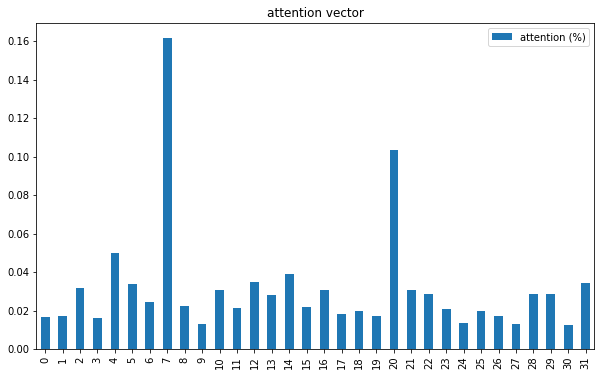

In [16]:
pd.DataFrame(attention_vector, columns=['attention (%)']).plot(figsize=(10, 6), kind='bar', title='attention vector')
# plt.show()

### LSTM - Attention

In [17]:
data_c = 300000
input_dims = 2
time_steps = 20
# true = attention vector is shared across the input_dimensions
SINGEL_ATTENTION_VECTOR = False

# APPLY_ATTENTION_BEFORE_LSTM = False
APPLY_ATTENTION_BEFORE_LSTM = True

In [18]:
def generate_recurrent_data(batch_size, time_steps, input_dims, attention_column=10):
    train_x = np.random.standard_normal(size=(batch_size, time_steps, input_dims))
    train_y = np.random.randint(low=0, high=2, size=(batch_size, 1))
    train_x[:, attention_column, :] = np.tile(train_y[:], (1, input_dims))
    return train_x, train_y

train_rx, train_ry = generate_recurrent_data(data_c, time_steps, input_dims)

In [19]:
def attention_3d_block(time_steps, input_layer, single_attention_vector):
    input_dim = int(input_layer.shape[2])
    a = Permute((2, 1))(input_layer)
    a = Reshape((input_dim, time_steps))(a)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    
    a_probs = Permute((2, 1), name='attention_vec')(a)
#     a_probs = Permute((2, 1))(a)
    output_attention_mul = multiply([input_layer, a_probs], name='attention_mul')
#     output_attention_mul = multiply([input_layer, a_probs])
    return output_attention_mul
    
#     https://github.com/philipperemy/keras-attention-mechanism/blob/master/attention_lstm.py

In [20]:
# apply on inputs
def model_atten_before_lstm(time_steps, input_dims):
    input_layer = Input(shape=(time_steps, input_dims))
    attention_mul = attention_3d_block(time_steps, input_layer, SINGEL_ATTENTION_VECTOR)
    lstm_units = 32
    attention_mul = LSTM(lstm_units, return_sequences=True)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[input_layer], output=output)
    return model

# apply on outputs
def model_atten_after_lstm(time_steps, input_dims):
    input_layer = Input(shape=(time_steps, input_dims, ))
    lstm_units = 32
    lstm_out = LSTM(lstm_units, return_sequences=True)(input_layer)
    attention_mul = attention_3d_block(time_steps, lstm_out, SINGEL_ATTENTION_VECTOR)
    attention_mul  = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[input_layer], output=output)
    return model

In [21]:
if APPLY_ATTENTION_BEFORE_LSTM:
    model = model_atten_before_lstm(time_steps, input_dims)
else:
    model = model_atten_after_lstm(time_steps, input_dims)
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/home/madigun/.pyenv/versions/3.6.7/envs/grace_jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  


In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 2)        0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 2, 20)        0           input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2, 20)        0           permute_1[0][0]                  
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2, 20)        420         reshape_1[0][0]                  
__________________________________________________________________________________________________
attention_

In [23]:
attention_vectors = []
for i in range(300):
    test_rx, test_ry = generate_recurrent_data(1, time_steps, input_dims)
    attention_vector = np.mean(get_activations(model, test_rx, print_shape_only=True, layer_name='attention_mul')[0], axis=2).squeeze()
    if i % 50 ==0:
        print('attention = ', attention_vector)
        assert(np.sum(attention_vector)-1.0) < 1e-5
    attention_vectors.append(attention_vector)

(1, 20, 2)
attention =  [-0.05047991 -0.00162791 -0.037816   -0.01665853 -0.00303603 -0.06609426
 -0.01130904 -0.00931512 -0.00420064  0.02398755  0.05528329 -0.00245764
  0.2958654   0.01233708  0.04457321 -0.01258763  0.07020381  0.01963383
 -0.01422871  0.00290396]
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
(1, 20, 2)
attention =  [-0.03533969  0.0246401  -0.00700516 -0.00271032  0.04707222 -0.00416335
  0.00270275  0.02283018  0.03365798  0.0570839   0.         -0.01785267
 -0.03114893 -0.051878

In [29]:
attention_vector_final = np.mean(np.array(attention_vectors), axis=0)
attention_vector_final

array([-0.01180851,  0.00585801, -0.01409213, -0.02533209, -0.00676676,
        0.00494408, -0.00210614,  0.00672438,  0.01409456,  0.00407073,
        0.0303301 ,  0.0123538 , -0.01600493,  0.01308461,  0.00420127,
       -0.00927497, -0.0078468 , -0.00122156, -0.01200515, -0.00425543],
      dtype=float32)

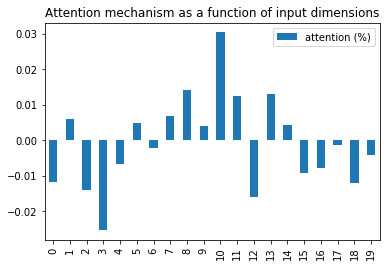

In [25]:
pd.DataFrame(attention_vector_final, columns=['attention (%)']).plot(kind='bar',
                                                                    title='Attention mechanism as a function of input dimensions')